In [1]:
# https://deeplearning4j.org/model-import-keras
# https://github.com/amir-abdi/Deep-Learning-Papers-Reading-Roadmap
# http://www.deeplearningbook.org/
#https://blog.openai.com

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split #pip install -U scikit-learn
from sklearn.preprocessing import MinMaxScaler

from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics

Using TensorFlow backend.


In [2]:
#################################################################################################
#Loading the data
datos = pd.read_csv('datos.csv')

#Shuffle
#np.random.shuffle(datos)
#datos = datos.sample(frac=1).reset_index(drop=True)
datos.sample(frac=1)

x_data = datos.drop(labels=['PTO_X', 'PTO_Y'], axis=1)
y_data = datos.drop(['WI0', 'WI1', 'WI2', 'WI3', 'WI4', 'WI5', 'WI6', 'WI7', 'WI8', 'WI9'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=101)

print("TRAIN DATA: ", x_train.shape)
print("TEST  DATA: ", x_test.shape)

TRAIN DATA:  (1579, 10)
TEST  DATA:  (678, 10)


In [3]:
#################################################################################################
#Normalizing the data

#NINGUNO = 8.638500279505998      10.156347279574847    8.474343137167798
#MinMaxScaler = 8.872573445861626   grafico = kk
#Mean = 7.977897581679846   grafico = ok
#min max = 10.18788741958436
"""
scaler = MinMaxScaler()
scaler.fit(x_train)
scaler.fit(x_test)
"""
#OR
"""
mean = x_train.mean(axis=0)
x_train -= mean
std = x_train.std(axis=0)
x_train /= std
x_test -= mean
x_test /= std
#--> Despreciable, si no lo haces en x_test deberías ver que no cambia error
print("MEAN:\n",mean, "\nSTD DEV:\n",std)
"""

#error = 7.403975049328515, 7.375712596870684
mean = x_train.mean(axis=0).mean()
std  = x_train.std(axis=0).std()
print("MEAN: %f,  STD DEV: %f" % (mean, std))
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std


#OR
"""
min = x_train.min().min()
max = x_train.max().max()
print("MIN: %f  MAX: %f" % (min, max))
x_train = (x_train - min)/(max - min)
x_test = (x_test - min)/(max - min)
"""

#separar validate & test data ?
x_valid = x_train[:400]
x_train2 = x_train[400:]
y_valid = y_train[:400]
y_train2 = y_train[400:]

MEAN: -65.301583,  STD DEV: 2.155530


In [4]:
#################################################################################################
#ANN Model
batch_size=128
epocas=49200
from keras import regularizers
reg = regularizers.l2(0.001)#*
reg = regularizers.l1_l2(l1=0.001, l2=0.001)#*
reg = regularizers.l1(0.001)#***
reg = None#**

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(7, activation='relu', input_shape=(x_data.shape[1],), name='cesin', kernel_regularizer=reg))
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    #model.add(layers.Dropout(0.05))#DROPOUT
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    #model.add(layers.Dropout(0.05))#DROPOUT
    model.add(layers.Dense(7, activation='relu', kernel_regularizer=reg))
    #model.add(layers.Dropout(0.05))#DROPOUT
    model.add(layers.Dense(2, name='cesout'))
    model.compile(optimizer=optimizers.RMSprop(lr=0.0001), loss=losses.mse, metrics=[metrics.mae])
    #model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [5]:
#################################################################################################
#Train the model  (ep: 22000)
model = build_model()

#hist = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epocas, batch_size=100, verbose=0)
#hist = model.fit(x_train2, y_train2, validation_data=(x_valid, y_valid), epochs=epocas, batch_size=batch_size, verbose=0)
hist = model.fit(x_train, y_train, validation_split=0.2, epochs=epocas, batch_size=batch_size, verbose=0)

C:\Anaconda3\lib\site-packages\keras\callbacks.py:116: UserWarning: Method on_batch_end() is slow compared to the batch update (0.114581). Check your callbacks.
  % delta_t_median)


Min error 36.723318 at epoch 30427


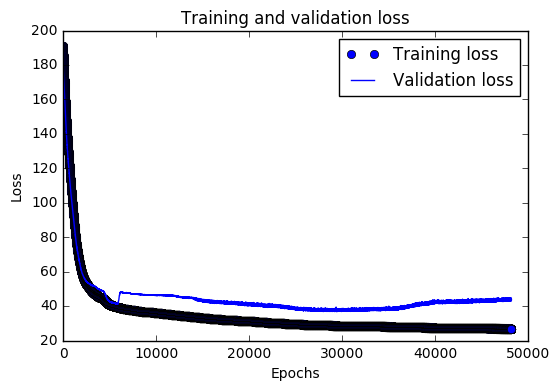

In [25]:
#################################################################################################
#Study the model
print("Min error %f at epoch %d" % (np.min(hist.history['val_loss'][:]), np.argmin(hist.history['val_loss'][:])))

loss = hist.history['loss'][1000:]
val_loss = hist.history['val_loss'][1000:]

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
#plt.xcorr
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
test_mse_score, test_mae_score = model.evaluate(x_test, y_test)
test_mae_score

678/678 [==============================] - 0s 96us/step


4.5540614339102685

In [26]:
#################################################################################################
#CES error
#
def calcError(real, pred):
    error = 0.
    real0 = np.asarray(real)
    for i in range(real.shape[0]):
        error = error + np.sqrt(pow(pred[i][0] - real0[i][0], 2) + pow(pred[i][1] - real0[i][1], 2))
    return error  /  real.shape[0]

###
y_predicted = model.predict(x_test)

error = calcError(y_test, y_predicted)
print("CES ERROR: ", error)
print("\n")

###
y_test0 = np.asarray(y_test)
for i in range(1,10):
    print("---------------> Real vs Pred.: (%.0f, %.0f) vs (%.0f, %.0f)      err(%.1f, %.1f)"
          % (y_test0[i][0], y_test0[i][1], y_predicted[i][0], y_predicted[i][1],
            y_test0[i][0] - y_predicted[i][0], y_test0[i][1] - y_predicted[i][1]))
print("\n")

CES ERROR:  7.1311945031380395


---------------> Real vs Pred.: (81, 41) vs (83, 46)      err(-1.8, -4.6)
---------------> Real vs Pred.: (73, 86) vs (64, 84)      err(8.5, 2.8)
---------------> Real vs Pred.: (67, 87) vs (77, 85)      err(-10.3, 2.5)
---------------> Real vs Pred.: (81, 46) vs (80, 44)      err(1.5, 2.1)
---------------> Real vs Pred.: (47, 74) vs (46, 82)      err(1.6, -7.9)
---------------> Real vs Pred.: (79, 68) vs (77, 63)      err(1.6, 5.3)
---------------> Real vs Pred.: (72, 45) vs (77, 36)      err(-5.5, 8.8)
---------------> Real vs Pred.: (81, 67) vs (78, 55)      err(2.4, 11.8)
---------------> Real vs Pred.: (0, 0) vs (0, -0)      err(-0.0, 0.5)




In [9]:
model.save("cesnet_last_"+str(error)+".h5")

In [10]:

k = 3
n_samples = x_data.size // x_data.shape[1] // k

print('Samples by fold: ', n_samples)
all_scores = []
all_hist = []
for i in range(k):
    print('processing fold #', i)

    x_valid3 = x_data[i * n_samples : (i + 1) * n_samples]
    y_valid3 = y_data[i * n_samples : (i + 1) * n_samples]
    x_data3 = np.concatenate([x_data[ : i * n_samples], x_data[(i + 1) * n_samples : ]], axis=0)
    y_data3 = np.concatenate([y_data[ : i * n_samples], y_data[(i + 1) * n_samples : ]], axis=0)

    model3 = build_model()
    hist3 = model3.fit(x_data3, y_data3, validation_data=(x_valid3, y_valid3), epochs=epocas, batch_size=batch_size, verbose=0)
    #all_hist.append(hist3.history['val_loss'])
    y_predicted = model3.predict(x_test)
    all_scores.append(calcError(y_test, y_predicted))
    all_hist.append(hist3.history['val_mean_absolute_error'])
    
    print("Min error %f at epoch %d" % (np.min(hist3.history['val_loss'][:]), np.argmin(hist3.history['val_loss'][:])))
    

Samples by fold:  752
processing fold # 0
Min error 79.758376 at epoch 44341
processing fold # 1
Min error 77.494270 at epoch 41998
processing fold # 2
Min error 105.003343 at epoch 48668


[62.59983537643253, 34.12129321073995, 40.76684351094211]


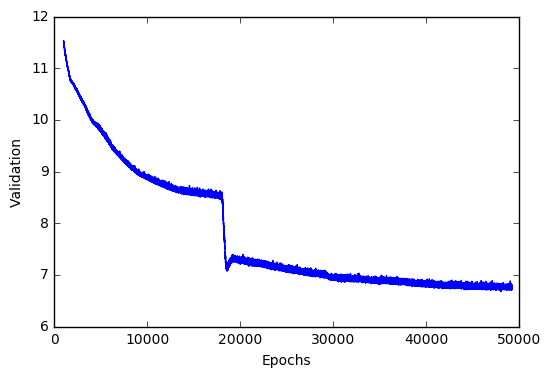

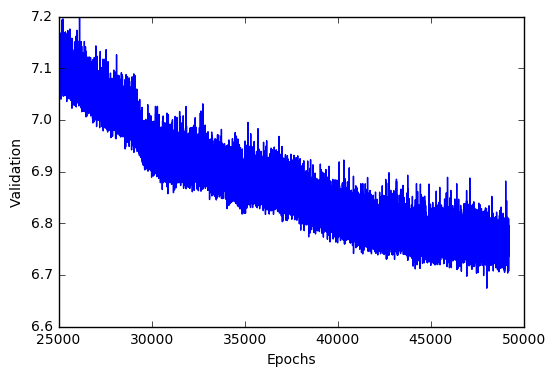

In [19]:
print(all_scores)
average_hist = [np.mean([x[i] for x in all_hist]) for i in range(epocas)]

"""
def smooth_curve(points, factor=1):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
        return smoothed_points
smooth_history = smooth_curve(average_hist[10:])
"""

offset0 = 1000
smooth_history = average_hist[offset0:]
plt.plot(range(1+offset0, len(smooth_history) + 1 + offset0), smooth_history)
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()

offset0 = 25010
smooth_history = average_hist[offset0:]#
plt.plot(range(1+offset0, len(smooth_history) + 1 + offset0), smooth_history)
plt.xlabel('Epochs')
plt.ylabel('Validation')
plt.show()

In [20]:
#Entrenar la red con todos los daton hasta la mejor epoca
epocas_optimas = 60000
x_data2 = (x_data - mean) / std

Una vez obtienes la mejor configuracion de metavariables (epochs, layers, neurons, etc) entrenas con todo x_data

In [21]:
#
model8 = build_model()
model8.fit(x_data2, y_data, epochs=epocas_optimas, batch_size=batch_size, verbose=0)
test_mse_score, test_mae_score = model8.evaluate(x_test, y_test)
print("test_mse_score=%f, test_mae_score=%f" % (test_mse_score, test_mae_score))
y_predicted = model8.predict(x_test)
error = calcError(y_test, y_predicted)
print("CES ERROR: ", error)
print("\n")


678/678 [==============================] - 0s 525us/step
test_mse_score=36.791677, test_mae_score=4.373339
CES ERROR:  6.7687579802208395




In [28]:
model8.save("cesnet_end1_"+str(error)+".h5")
model8.save("cesnet_end1.h5")

In [22]:
#
model9 = build_model()
model9.fit(x_data2, y_data, validation_data=(x_valid, y_valid), epochs=epocas_optimas, batch_size=batch_size, verbose=0)
test_mse_score, test_mae_score = model9.evaluate(x_test, y_test)
print("test_mse_score=%f, test_mae_score=%f" % (test_mse_score, test_mae_score))
y_predicted = model9.predict(x_test)
error = calcError(y_test, y_predicted)
print("CES ERROR: ", error)
print("\n")


678/678 [==============================] - 0s 46us/step
test_mse_score=31.881342, test_mae_score=4.112140
CES ERROR:  6.462209725887058




In [29]:
model9.save("cesnet_end2_"+str(error)+".h5")
model9.save("cesnet_end2.h5")

TODO: Reinforcement Learning ANN / Deep Q-Learning /(https://github.com/openai/gym)
TODO: Variar las entradas...